In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='gray')
import matplotlib.animation
%matplotlib ipympl
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import cv2
from tqdm import tqdm
tqdm.pandas()
import random
from stardist import _draw_polygons
from stardist.models import StarDist2D
from csbdeep.utils import normalize
import skimage
from scipy.optimize import dual_annealing, minimize
from tifffile import imsave, imread
import trackpy as tp

from tracking_utils import *

In [2]:
#model_name = 'stardist_trained'          # stardist model trained for 50 epochs on simulated synthetic dataset
#model_name = 'modified_2D_versatile_fluo' # stardist model trained for 150 epochs on simulated dataset starting from the pretrained 2D versatile fluo model
#model_name = 'modified_2D_versatile_fluo_1000x1000_v2'

model_name = 'modified_2D_versatile_fluo_synthetic_dataset_100_fps_r_decay_r_gaussian_only_optimization'

resolution = 1000
model = StarDist2D(None, name = model_name, basedir = './models/')
video_selection =  "49b1r"# "25b25r-1"

if video_selection == "25b25r-1":
    xmin, ymin, xmax, ymax = 95, 30, 535, 470 
    merge_present = False   
elif video_selection == "25b25r-2":
    xmin, ymin, xmax, ymax = 82, 13, 410, 342 
    merge_present = False   
elif video_selection == "49b1r":
    xmin, ymin, xmax, ymax = 20, 50, 900, 930
    merge_present = True
    merge_frame = 32269


save_path       = f'./{video_selection}/{model_name}/'
source_path     = f'./data/{video_selection}.mp4'
system_name     = f'{video_selection} system'
nDrops = 50

video = cv2.VideoCapture(source_path)
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video.get(cv2.CAP_PROP_FPS))
n_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Video has {n_frames} frames with a resolution of {w}x{h} and a framerate of {fps} fps")

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.886451, nms_thresh=0.3.
Video has 80794 frames with a resolution of 920x960 and a framerate of 10 fps


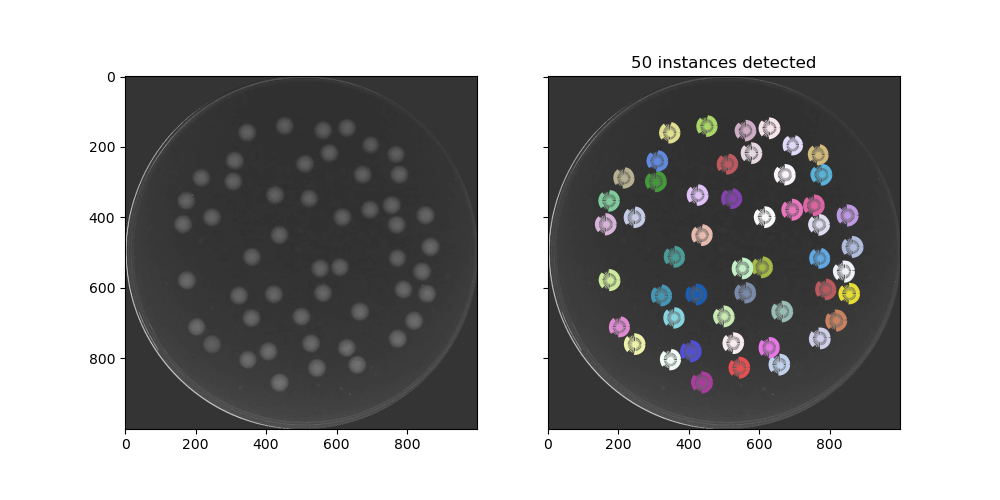

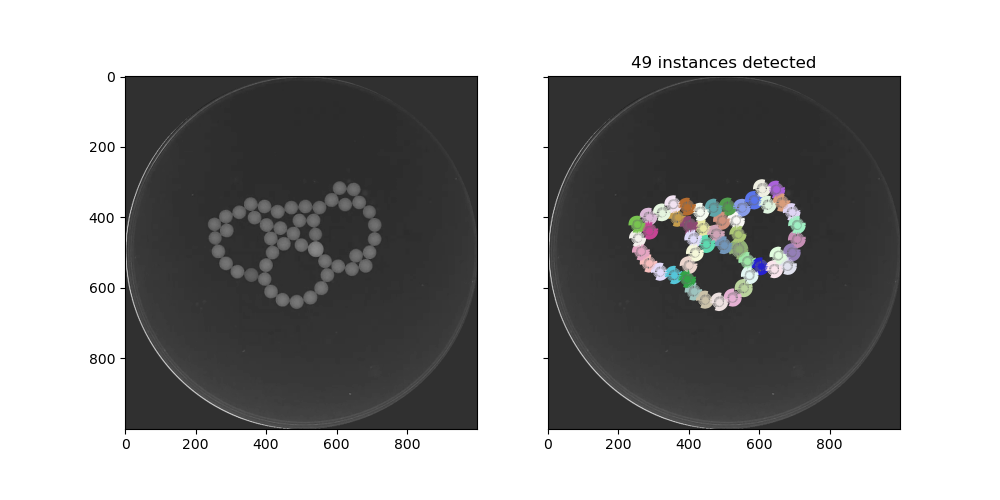

In [3]:
img = get_frame(video, 0, xmin, ymin, xmax, ymax, w, h, resolution, True)
label, details = model.predict_instances(normalize(img), predict_kwargs = {'verbose' : False})
coord, points, prob = details['coord'], details['points'], details['prob']

img2 = get_frame(video, n_frames -1, xmin, ymin, xmax, ymax, w, h, resolution, True)
label2, details2 = model.predict_instances(normalize(img2), predict_kwargs = {'verbose' : False})
coord2, points2, prob2 = details2['coord'], details2['points'], details2['prob']

fig, ax = plt.subplots(1, 2, figsize = (10, 5), sharex=True, sharey=True)
ax[0].imshow(img, cmap = 'gray')
_draw_polygons(coord, points, prob, show_dist=True)
ax[1].imshow(img, cmap = 'gray')
ax[1].set(title = f'{len(prob)} instances detected')
plt.savefig(save_path + f'test_first_frame.pdf', format = 'pdf')
plt.show()

fig, ax = plt.subplots(1, 2, figsize = (10, 5), sharex=True, sharey=True)
ax[0].imshow(img2, cmap = 'gray')
ax[1].imshow(img2, cmap = 'gray')
_draw_polygons(coord2, points2, prob2, show_dist=True)
ax[1].set(title = f'{len(prob2)} instances detected')
plt.savefig(save_path + f'test_last_frame.pdf', format = 'pdf')
plt.show()

In [5]:
test_verb = False
detect_verb = False
link_verb = False
interp_verb = False

startFrame = 0
endFrame = n_frames
frames = np.arange(startFrame, endFrame, 1, dtype=int)

In [6]:
if test_verb:
    n_samples = 1000
    test_detection_df = test_detection(n_samples, n_frames, nDrops, video_selection, merge_frame, model, model_name, video, xmin, ymin, xmax, ymax, w, h, resolution, save_path)

In [27]:
if detect_verb:
    print(f'Processing from {int(startFrame/fps)} s to {int(endFrame/fps)} s')
    
    raw_detection_df = detect_instances(frames, False, video_selection, model, model_name, video, xmin, ymin, xmax, ymax, w, h, resolution, save_path)
    
    n_feature_per_frame = raw_detection_df.groupby('frame').count().x.values
    fig, ax = plt.subplots(2, 2, figsize = (8, 4))
    ax[0, 0].scatter(raw_detection_df.frame.unique(), n_feature_per_frame, s=0.1)
    ax[0, 0].set(xlabel = 'Frame', ylabel = 'N of droplets', title = 'N of droplets per frame')
    ax[0, 1].scatter(raw_detection_df.frame, raw_detection_df.r, s=0.1)
    ax[0, 1].set(xlabel = 'Instance index', ylabel = 'Radius [px]', title = 'Radius of instances detected')
    ax[1, 0].scatter(raw_detection_df.r, raw_detection_df.eccentricity, s=0.1)
    ax[1, 0].set(xlabel = 'Radius [px]', ylabel='Eccentricity', title='R-eccentricity correlation')
    ax[1, 1].scatter(raw_detection_df.r, raw_detection_df.prob, s=0.1)
    ax[1, 1].set(xlabel = 'Radius [px]', ylabel='Probability', title='R-Probability correlation')
    plt.tight_layout()
    plt.savefig(save_path + f'raw_instances_{model_name}_{frames[0]}_{frames[-1]}.png', dpi = 500)
    plt.close()
else:
    raw_detection_df = pd.read_parquet(save_path + f'raw_detection_{video_selection}_{model_name}_{frames[0]}_{frames[-1]}.parquet')
    frames = raw_detection_df.frame.unique()

    n_feature_per_frame = raw_detection_df.groupby('frame').count().x.values
    fig, ax = plt.subplots(2, 2, figsize = (8, 4))
    ax[0, 0].scatter(raw_detection_df.frame.unique(), n_feature_per_frame, s=0.1)
    ax[0, 0].set(xlabel = 'Frame', ylabel = 'N of droplets', title = 'N of droplets per frame')
    ax[0, 1].scatter(raw_detection_df.frame, raw_detection_df.r, s=0.1)
    ax[0, 1].set(xlabel = 'Instance index', ylabel = 'Radius [px]', title = 'Radius of instances detected')
    ax[1, 0].scatter(raw_detection_df.r, raw_detection_df.eccentricity, s=0.1)
    ax[1, 0].set(xlabel = 'Radius [px]', ylabel='Eccentricity', title='R-eccentricity correlation')
    ax[1, 1].scatter(raw_detection_df.r, raw_detection_df.prob, s=0.1)
    ax[1, 1].set(xlabel = 'Radius [px]', ylabel='Probability', title='R-Probability correlation')
    plt.tight_layout()
    plt.savefig(save_path + f'raw_instances_{model_name}_{frames[0]}_{frames[-1]}.png', dpi = 500)
    plt.close()

In [15]:
if merge_present:
    err_frames_pre_merge = np.where(raw_detection_df.loc[raw_detection_df.frame < merge_frame].groupby('frame').count().x.values != nDrops)[0]
    err_frames_post_merge = merge_frame + np.where(raw_detection_df.loc[raw_detection_df.frame >= merge_frame].groupby('frame').count().x.values != nDrops-1)[0] 
    print(f'Number of errors: {len(err_frames_pre_merge)} / {len(frames[:merge_frame])} --> {len(err_frames_pre_merge)/len(frames[:merge_frame])*100:.2f}%')
    print(f'Number of errors: {len(err_frames_post_merge)} / {len(frames[merge_frame:])} --> {len(err_frames_post_merge)/len(frames[merge_frame:])*100:.2f}%')
    condition = np.ediff1d(err_frames_pre_merge)
    condition[condition == 1] = True
    condition[condition != 1] = False
    if 1 in condition:
        max_n_of_consecutive_errs_pre_merge = max(np.diff(np.where(np.concatenate(([condition[0]], condition[:-1] != condition[1:], [True])))[0])[::2])
        print(f'Max number of consecutive errors pre merge: {max_n_of_consecutive_errs_pre_merge}')
    else:
        max_n_of_consecutive_errs_pre_merge = 0
        print(f'Max number of consecutive errors pre merge: 0')
    condition = np.ediff1d(err_frames_post_merge)
    condition[condition == 1] = True
    condition[condition != 1] = False
    if 1 in condition:
        max_n_of_consecutive_errs_post_merge = max(np.diff(np.where(np.concatenate(([condition[0]], condition[:-1] != condition[1:], [True])))[0])[::2])
        print(f'Max number of consecutive errors post merge: {max_n_of_consecutive_errs_post_merge}')
    else:
        max_n_of_consecutive_errs_post_merge = 0
        print(f'Max number of consecutive errors post merge: 0')
else:
    err_frames = np.where(raw_detection_df.groupby('frame').count().x.values != nDrops)[0]
    print(f'Number of errors: {len(err_frames)} / {len(frames)} --> {len(err_frames)/len(frames)*100:.2f}%')
    condition = np.ediff1d(err_frames)
    condition[condition == 1] = True
    condition[condition != 1] = False
    if 1 in condition:
        max_n_of_consecutive_errs = max(np.diff(np.where(np.concatenate(([condition[0]], condition[:-1] != condition[1:], [True])))[0])[::2])
        print(f'Max number of consecutive errors: {max_n_of_consecutive_errs}')
    else:
        max_n_of_consecutive_errs = 0
        print(f'Max number of consecutive errors: 0')

Number of errors: 898 / 32269 --> 2.78%
Number of errors: 161 / 48525 --> 0.33%
Max number of consecutive errors pre merge: 31
Max number of consecutive errors post merge: 10


In [16]:
if link_verb:
    if merge_present:
        print('Linking trajectories...')
        cutoff = 200

        ## PRE MERGE
        t = tp.link_df(raw_detection_df.loc[raw_detection_df.frame < merge_frame], cutoff,\
                       memory = max_n_of_consecutive_errs_pre_merge, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
        t = t.sort_values(['frame', 'particle'])
        trajectories_pre_merge = tp.filter_stubs(t, 2500)
        # CREATE COLOR COLUMN AND SAVE DF
        n = max(trajectories_pre_merge.particle)
        print(f'N of droplets pre merge: {n + 1}')
        random.seed(5)
        colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
        for i in range(max(trajectories_pre_merge.particle)+1-n):
            colors.append('#00FFFF')
        c = []
        for p in trajectories_pre_merge.particle:
            c.append(colors[p])
        trajectories_pre_merge['color'] = c
        trajectories_pre_merge = trajectories_pre_merge.reset_index(drop=True)
        trajectories_pre_merge.to_parquet(save_path + f'raw_tracking_{video_selection}_{model_name}_pre_merge.parquet', index = False)

        ## POST MERGE
        t = tp.link_df(raw_detection_df.loc[raw_detection_df.frame >= merge_frame], cutoff,\
                       memory = max_n_of_consecutive_errs_post_merge, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
        t = t.sort_values(['frame', 'particle'])
        trajectories_post_merge = tp.filter_stubs(t, 2500)
        # CREATE COLOR COLUMN AND SAVE DF
        n = max(trajectories_post_merge.particle)
        print(f'N of droplets post merge: {n + 1}')
        random.seed(5)
        colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
        for i in range(max(trajectories_post_merge.particle)+1-n):
            colors.append('#00FFFF')
        c = []
        for p in trajectories_post_merge.particle:
            c.append(colors[p])
        trajectories_post_merge['color'] = c
        trajectories_post_merge = trajectories_post_merge.reset_index(drop=True)
        trajectories_post_merge.to_parquet(save_path + f'raw_tracking_{video_selection}_{model_name}_post_merge.parquet', index = False)
    else:
        print('Linking trajectories...')
        cutoff = 200
        t = tp.link_df(raw_detection_df, cutoff, memory = max_n_of_consecutive_errs + 10,\
                       link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
        t = t.sort_values(['frame', 'particle'])
        trajectories = tp.filter_stubs(t, 2500)
        # CREATE COLOR COLUMN AND SAVE DF
        n = max(trajectories.particle)
        print(f'N of droplets: {n + 1}')
        random.seed(5)
        colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
        for i in range(max(trajectories.particle)+1-n):
            colors.append('#00FFFF')
        c = []
        for p in trajectories.particle:
            c.append(colors[p])
        trajectories['color'] = c
        trajectories = trajectories.reset_index(drop=True)
        trajectories.to_parquet(save_path + f'raw_tracking_{video_selection}_{model_name}_{frames[0]}_{frames[-1]}.parquet', index = False)
else:
    if merge_present:
        print('Importing linked trajectories...')
        trajectories_pre_merge = pd.read_parquet(save_path + f'raw_tracking_{video_selection}_{model_name}_pre_merge.parquet')
        trajectories_post_merge = pd.read_parquet(save_path + f'raw_tracking_{video_selection}_{model_name}_post_merge.parquet')
    else:
        print('Importing linked trajectories...')
        trajectories = pd.read_parquet(save_path + f'raw_tracking_{video_selection}_{model_name}_{frames[0]}_{frames[-1]}.parquet')

Frame 80793: 49 trajectories present.
N of droplets post merge: 49


In [34]:
if merge_present:
    trajectories = pd.concat((trajectories_pre_merge, trajectories_post_merge)).reset_index(drop=True)

if merge_present:
    err_frames_pre_merge = np.where(trajectories.loc[trajectories.frame < merge_frame].groupby('frame').count().x.values != nDrops)[0]
    err_frames_post_merge = merge_frame + np.where(trajectories.loc[trajectories.frame >= merge_frame].groupby('frame').count().x.values != nDrops-1)[0] 
    print(f'Number of errors: {len(err_frames_pre_merge)} / {len(frames[:merge_frame])} --> {len(err_frames_pre_merge)/len(frames[:merge_frame])*100:.2f}%')
    print(f'Number of errors: {len(err_frames_post_merge)} / {len(frames[merge_frame:])} --> {len(err_frames_post_merge)/len(frames[merge_frame:])*100:.2f}%')
    condition = np.ediff1d(err_frames_pre_merge)
    condition[condition == 1] = True
    condition[condition != 1] = False
    if 1 in condition:
        max_n_of_consecutive_errs_pre_merge = max(np.diff(np.where(np.concatenate(([condition[0]], condition[:-1] != condition[1:], [True])))[0])[::2])
        print(f'Max number of consecutive errors pre merge: {max_n_of_consecutive_errs_pre_merge}')
    else:
        max_n_of_consecutive_errs_pre_merge = 0
        print(f'Max number of consecutive errors pre merge: 0')
    condition = np.ediff1d(err_frames_post_merge)
    condition[condition == 1] = True
    condition[condition != 1] = False
    if 1 in condition:
        max_n_of_consecutive_errs_post_merge = max(np.diff(np.where(np.concatenate(([condition[0]], condition[:-1] != condition[1:], [True])))[0])[::2])
        print(f'Max number of consecutive errors post merge: {max_n_of_consecutive_errs_post_merge}')
    else:
        max_n_of_consecutive_errs_post_merge = 0
        print(f'Max number of consecutive errors post merge: 0')
else:
    err_frames = np.where(trajectories.groupby('frame').count().x.values != nDrops)[0]
    print(f'Number of errors: {len(err_frames)} / {len(frames)} --> {len(err_frames)/len(frames)*100:.2f}%')
    condition = np.ediff1d(err_frames)
    condition[condition == 1] = True
    condition[condition != 1] = False
    if 1 in condition:
        max_n_of_consecutive_errs = max(np.diff(np.where(np.concatenate(([condition[0]], condition[:-1] != condition[1:], [True])))[0])[::2])
        print(f'Max number of consecutive errors: {max_n_of_consecutive_errs}')
    else:
        max_n_of_consecutive_errs = 0
        print(f'Max number of consecutive errors: 0')

err_frame = trajectories.loc[trajectories.particle == max(trajectories.particle.unique())].frame.min()
if err_frame != 0:
    fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)
    ax.imshow(get_frame(video, err_frame - 2, xmin, ymin, xmax, ymax, w, h, resolution, True))
    ax.set(xlabel = 'X [px]', ylabel = 'Y [px]', title = f'Frame {err_frame - 2}')
    for i in range(len(trajectories.loc[trajectories.frame == err_frame - 2])):
        ax.add_artist(plt.Circle((trajectories.loc[trajectories.frame == err_frame - 2].x.values[i], trajectories.loc[trajectories.frame == err_frame - 2].y.values[i]),\
                                trajectories.loc[trajectories.frame == err_frame - 2].r.values[i], color = trajectories.loc[trajectories.frame == err_frame - 2].color.values[i],\
                                fill = True))
    ax1.imshow(get_frame(video, err_frame - 1, xmin, ymin, xmax, ymax, w, h, resolution, True))
    ax1.set(xlabel = 'X [px]', ylabel = 'Y [px]', title = f'Frame {err_frame - 1}')
    for i in range(len(trajectories.loc[trajectories.frame == err_frame - 1])):
        ax1.add_artist(plt.Circle((trajectories.loc[trajectories.frame == err_frame - 1].x.values[i], trajectories.loc[trajectories.frame == err_frame - 1].y.values[i]),\
                                trajectories.loc[trajectories.frame == err_frame - 1].r.values[i], color = trajectories.loc[trajectories.frame == err_frame - 1].color.values[i],\
                                fill = True))
    ax2.imshow(get_frame(video, err_frame, xmin, ymin, xmax, ymax, w, h, resolution, True))
    ax2.set(xlabel = 'X [px]', ylabel = 'Y [px]', title = f'Frame {err_frame}')
    for i in range(len(trajectories.loc[trajectories.frame == err_frame])):
        ax2.add_artist(plt.Circle((trajectories.loc[trajectories.frame == err_frame].x.values[i], trajectories.loc[trajectories.frame == err_frame].y.values[i]),\
                                trajectories.loc[trajectories.frame == err_frame].r.values[i], color = trajectories.loc[trajectories.frame == err_frame].color.values[i],\
                                fill = True))
    plt.tight_layout()
    plt.show()

Number of errors: 1 / 32269 --> 0.00%
Number of errors: 50 / 48525 --> 0.10%
Max number of consecutive errors pre merge: 0
Max number of consecutive errors post merge: 4


In [29]:
if merge_present:
    trajectories = pd.concat((trajectories_pre_merge, trajectories_post_merge)).reset_index(drop=True)
n_feature_per_frame = trajectories.groupby('frame').count().x.values
fig, ax = plt.subplots(2, 2, figsize = (8, 4))
ax[0, 0].scatter(trajectories.frame.unique(), n_feature_per_frame, s=0.1)
ax[0, 0].set(xlabel = 'Frame', ylabel = 'N of droplets', title = 'N of droplets per frame')
ax[0, 1].scatter(trajectories.frame, trajectories.r, s=0.1)
ax[0, 1].set(xlabel = 'Instance index', ylabel = 'Radius [px]', title = 'Radius of instances detected')
ax[1, 0].scatter(trajectories.r, trajectories.eccentricity, s=0.1)
ax[1, 0].set(xlabel = 'Radius [px]', ylabel='Eccentricity', title='R-eccentricity correlation')
ax[1, 1].scatter(trajectories.r, trajectories.prob, s=0.1)
ax[1, 1].set(xlabel = 'Radius [px]', ylabel='Probability', title='R-Probability correlation')
plt.tight_layout()
plt.savefig(save_path + f'linked_instances_{model_name}_{frames[0]}_{frames[-1]}.png', dpi = 500)
plt.close()

In [23]:
if interp_verb:
    if merge_present:
        print('Interpolating trajectories...')
        interp_trajectories_pre_merge = trajectories_pre_merge.groupby('particle').progress_apply(interpolate_trajectory)
        interp_trajectories_pre_merge = interp_trajectories_pre_merge.reset_index(drop=True)
        interp_trajectories_pre_merge['particle'] = interp_trajectories_pre_merge['particle'].astype(int)
        interp_trajectories_pre_merge = interp_trajectories_pre_merge.sort_values(['frame', 'particle'])
        interp_trajectories_pre_merge.to_parquet(save_path + f'interpolated_tracking_{video_selection}_{model_name}_pre_merge.parquet', index=False)

        interp_trajectories_post_merge = trajectories_post_merge.groupby('particle').progress_apply(interpolate_trajectory)
        interp_trajectories_post_merge = interp_trajectories_post_merge.reset_index(drop=True)
        interp_trajectories_post_merge['particle'] = interp_trajectories_post_merge['particle'].astype(int)
        interp_trajectories_post_merge = interp_trajectories_post_merge.sort_values(['frame', 'particle'])
        interp_trajectories_post_merge.to_parquet(save_path + f'interpolated_tracking_{video_selection}_{model_name}_post_merge.parquet', index=False)
    else:
        print('Interpolating trajectories...')
        interp_trajectories = trajectories.groupby('particle').progress_apply(interpolate_trajectory)
        
        interp_trajectories['particle'] = interp_trajectories['particle'].astype(int)
        interp_trajectories = interp_trajectories.sort_values(['frame', 'particle'])
        interp_trajectories = interp_trajectories.reset_index(drop=True)
        interp_trajectories.to_parquet(save_path + f'interpolated_tracking_{video_selection}_{model_name}_{startFrame}_{endFrame}.parquet', index=False)
else:
    if merge_present:
        print('Importing interpolated trajectories...')
        interp_trajectories_pre_merge = pd.read_parquet(save_path + f'interpolated_tracking_{video_selection}_{model_name}_pre_merge.parquet')
        interp_trajectories_post_merge = pd.read_parquet(save_path + f'interpolated_tracking_{video_selection}_{model_name}_post_merge.parquet')
    else:
        print('Importing interpolated trajectories...')
        interp_trajectories = pd.read_parquet(save_path + f'interpolated_tracking_{video_selection}_{model_name}_{startFrame}_{endFrame}.parquet')

Interpolating trajectories...


100%|██████████| 49/49 [00:01<00:00, 33.16it/s]


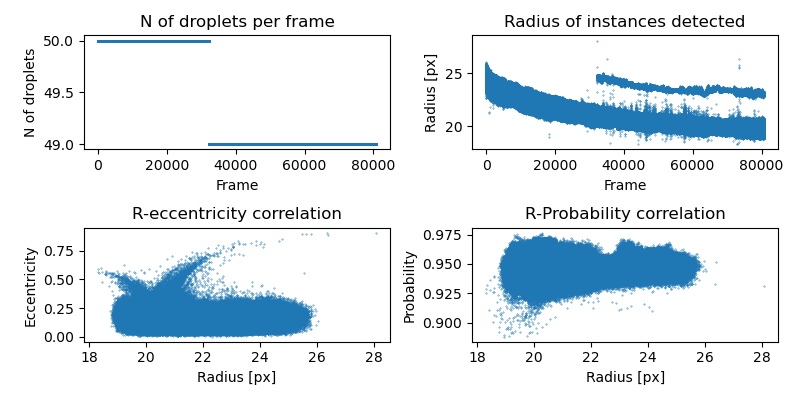

In [24]:
if merge_present:
    interp_trajectories = pd.concat((interp_trajectories_pre_merge, interp_trajectories_post_merge)).reset_index(drop=True)
n_feature_per_frame = interp_trajectories.groupby('frame').count().x.values

fig, ax = plt.subplots(2, 2, figsize = (8, 4))
ax[0, 0].scatter(interp_trajectories.frame.unique(), n_feature_per_frame, s=0.1)
ax[0, 0].set(xlabel = 'Frame', ylabel = 'N of droplets', title = 'N of droplets per frame')
ax[0, 1].scatter(interp_trajectories.frame, interp_trajectories.r,  s=0.1)
ax[0, 1].set(xlabel = 'Frame', ylabel = 'Radius [px]', title = 'Radius of instances detected')
ax[1, 0].scatter(interp_trajectories.r, interp_trajectories.eccentricity, s=0.1)
ax[1, 0].set(xlabel = 'Radius [px]', ylabel='Eccentricity', title='R-eccentricity correlation')
ax[1, 1].scatter(interp_trajectories.r, interp_trajectories.prob, s=0.1)
ax[1, 1].set(xlabel = 'Radius [px]', ylabel='Probability', title='R-Probability correlation')
plt.tight_layout()
plt.savefig(save_path + f'interp_instances_{model_name}_{startFrame}_{endFrame}.png', dpi = 500)
plt.show()

In [ ]:
if 0:
    if merge_present:
        interp_trajectories_subsampled_pre_merge = interp_trajectories_pre_merge.loc[interp_trajectories_pre_merge.frame.isin(interp_trajectories_pre_merge.frame.unique()[::int(fps/10)]), ["x", "y", "r", "frame", "particle", "color"]]
        interp_trajectories_subsampled_pre_merge['frame'] = np.array(interp_trajectories_subsampled_pre_merge.frame/int(fps/10)).astype(int)
        smooth_trajs_pre_merge = get_smooth_trajs(interp_trajectories_subsampled_pre_merge, windLen = 10, orderofPoly = 4)
        ts1 = smooth_trajs_pre_merge.copy()
        ts1["color"] = ts1["color"].astype("category")
        ts1["particle"] = pd.to_numeric(ts1["particle"], downcast="integer")
        ts1["frame"] = pd.to_numeric(ts1["frame"], downcast="integer")
        ts1["x"] = pd.to_numeric(ts1["x"], downcast="float")
        ts1["y"] = pd.to_numeric(ts1["y"], downcast="float")
        ts1["r"] = pd.to_numeric(ts1["r"], downcast="float")
        ts1 = ts1.sort_values(['frame', 'particle'])
        display(ts1.memory_usage(deep=True))
        display(ts1.dtypes)
        reduction = ts1.memory_usage(deep=True).sum() / smooth_trajs_pre_merge.memory_usage(deep=True).sum()
        print(f" Reduced to {reduction*100:0.4f} % of the original size")
        ts1.to_parquet(save_path + f'{video_selection}_subsampled{int(fps/10)}_smoothed_windlen10_orderofpoly4_pre_merge', index=False, engine='pyarrow', partition_cols=['particle'])

        interp_trajectories_subsampled_post_merge = interp_trajectories_post_merge.loc[interp_trajectories_post_merge.frame.isin(interp_trajectories_post_merge.frame.unique()[::int(fps/10)]), ["x", "y", "r", "frame", "particle", "color"]]
        interp_trajectories_subsampled_post_merge['frame'] = np.array(interp_trajectories_subsampled_post_merge.frame/int(fps/10)).astype(int)
        smooth_trajs_post_merge = get_smooth_trajs(interp_trajectories_subsampled_post_merge, windLen = 10, orderofPoly = 4)
        ts2 = smooth_trajs_post_merge.copy()
        ts2["color"] = ts2["color"].astype("category")
        ts2["particle"] = pd.to_numeric(ts2["particle"], downcast="integer")
        ts2["frame"] = pd.to_numeric(ts2["frame"], downcast="integer")
        ts2["x"] = pd.to_numeric(ts2["x"], downcast="float")
        ts2["y"] = pd.to_numeric(ts2["y"], downcast="float")
        ts2["r"] = pd.to_numeric(ts2["r"], downcast="float")
        ts2 = ts2.sort_values(['frame', 'particle'])
        display(ts2.memory_usage(deep=True))
        display(ts2.dtypes)
        reduction = ts2.memory_usage(deep=True).sum() / smooth_trajs_post_merge.memory_usage(deep=True).sum()
        print(f" Reduced to {reduction*100:0.4f} % of the original size")
        ts2.to_parquet(save_path + f'{video_selection}_subsampled{int(fps/10)}_smoothed_windlen10_orderofpoly4_post_merge', index=False, engine='pyarrow', partition_cols=['particle'])
    else:
        interp_trajectories_subsampled = interp_trajectories.loc[interp_trajectories.frame.isin(interp_trajectories.frame.unique()[::int(fps/10)]), ["x", "y", "r", "frame", "particle", "color"]]
        interp_trajectories_subsampled['frame'] = np.array(interp_trajectories_subsampled.frame/int(fps/10)).astype(int)
        smooth_trajs = get_smooth_trajs(interp_trajectories_subsampled, windLen = 10, orderofPoly = 4)
        ts2 = smooth_trajs.copy()
        ts2["color"] = ts2["color"].astype("category")
        ts2["particle"] = pd.to_numeric(ts2["particle"], downcast="integer")
        ts2["frame"] = pd.to_numeric(ts2["frame"], downcast="integer")
        ts2["x"] = pd.to_numeric(ts2["x"], downcast="float")
        ts2["y"] = pd.to_numeric(ts2["y"], downcast="float")
        ts2["r"] = pd.to_numeric(ts2["r"], downcast="float")
        ts2 = ts2.sort_values(['frame', 'particle'])
        display(ts2.memory_usage(deep=True))
        display(ts2.dtypes)
        reduction = ts2.memory_usage(deep=True).sum() / smooth_trajs.memory_usage(deep=True).sum()
        print(f" Reduced to {reduction*100:0.4f} % of the original size")
        ts2.to_parquet(save_path + f'{video_selection}_subsampled{int(fps/10)}_smoothed_windlen10_orderofpoly4', index=False, engine='pyarrow', partition_cols=['particle'])

In [ ]:
if 0:
    fig, ax = fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    def update_graph(frame):
        df = interp_trajectories.loc[(interp_trajectories.frame == frame), ["x", "y", "r", 'color']]
        for i in range(len(df)):
            graph[i].center = (df.x.values[i], df.y.values[i])
            graph[i].radius = df.r.values[i]
        graph2.set_data(get_frame(video, frame, xmin, ymin, xmax, ymax, w, h, False))
        title.set_text(f'{system_name} Tracking -- t = {round(frame/fps, 1)} s')
        return graph

    title = ax.set_title(f'{system_name} Tracking -- t = {0} s')
    ax.set(xlabel = 'X [px]', ylabel = 'Y [px]')
    df = interp_trajectories.loc[(interp_trajectories.frame == min(interp_trajectories.frame.unique())), ["x", "y", "r", 'color']]
    graph = []
    for i in range(len(df)):
        graph.append(ax.add_artist(plt.Circle((df.x.values[i], df.y.values[i]), df.r.values[i], color = df.color.values[i],\
                                            fill = False)))
    graph2 = ax.imshow(get_frame(video, 0, xmin, ymin, xmax, ymax, w, h, False))
    ani = matplotlib.animation.FuncAnimation(fig, update_graph, interp_trajectories.frame.unique(), interval = 5, blit=False)
    writer = matplotlib.animation.FFMpegWriter(fps = 30, metadata = dict(artist='Matteo Scandola'), extra_args=['-vcodec', 'libx264'])
    ani.save(f'./{save_path}/tracking_video2.mp4', writer=writer, dpi = 200)
    plt.close()

In [50]:
print(np.concatenate((err_frames_pre_merge, err_frames_post_merge)))
print(np.concatenate((err_frames_pre_merge, err_frames_post_merge)).shape)

trajectories.loc[trajectories.frame == 73391].particle.unique() 

[32268 35077 35078 35079 35991 35999 36911 36912 36963 36964 36966 39492
 39493 44105 44479 44672 45999 46547 46549 46759 46760 46763 48504 49100
 51982 52068 52196 52492 53516 53517 56536 56652 56962 57604 57624 57687
 60232 64000 64079 64080 66528 66785 72889 73391 73392 73393 73394 73395
 73494 73716 77972]
(51,)


array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [56]:
if video_selection == "49b1r":
    test_frames = [73391, 73392, 73393, 73394, 73395]
    missing_droplet_id = 3

smooth_trajs = get_smooth_trajs(interp_trajectories, windLen = 10, orderofPoly = 4)

df1 = trajectories.loc[(trajectories.frame < max(test_frames) + 15) & (trajectories.frame > min(test_frames) - 15) & (trajectories.particle == 3)]
df2 = interp_trajectories.loc[(interp_trajectories.frame < max(test_frames) + 15) & (interp_trajectories.frame > min(test_frames) - 15) & (interp_trajectories.particle == 3)]
df3 = smooth_trajs.loc[(smooth_trajs.frame < max(test_frames) + 15) & (smooth_trajs.frame > min(test_frames) - 15) & (smooth_trajs.particle == 3)]

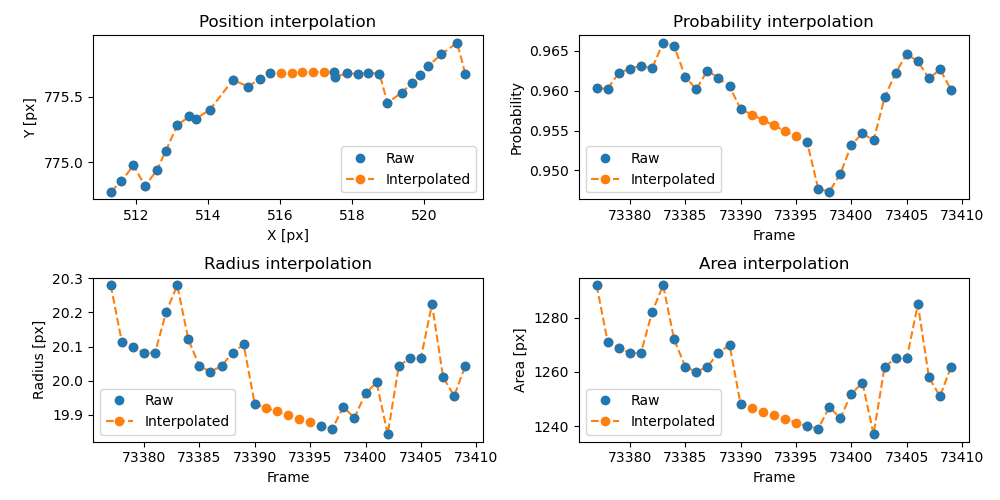

In [58]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0,0].plot(df1.x, df1.y, 'o', label = 'Raw', zorder = 20)
ax[0,0].plot(df2.x, df2.y, '--o', label = 'Interpolated', zorder = 10)
ax[0,0].set(xlabel = 'X [px]', ylabel = 'Y [px]', title = 'Position interpolation')
ax[0,0].legend()
ax[1,0].plot(df1.frame, df1.r, 'o', label = 'Raw', zorder = 20)
ax[1,0].plot(df2.frame, df2.r, '--o', label = 'Interpolated', zorder = 10)
ax[1,0].set(xlabel = 'Frame', ylabel = 'Radius [px]', title = 'Radius interpolation')
ax[1,0].legend()
ax[0,1].plot(df1.frame, df1.prob, 'o', label = 'Raw', zorder = 20)
ax[0,1].plot(df2.frame, df2.prob, '--o', label = 'Interpolated', zorder = 10)
ax[0,1].set(xlabel = 'Frame', ylabel = 'Probability', title = 'Probability interpolation')
ax[0,1].legend()
ax[1,1].plot(df1.frame, df1.area, 'o', label = 'Raw', zorder = 20)
ax[1,1].plot(df2.frame, df2.area, '--o', label = 'Interpolated', zorder = 10)
ax[1,1].set(xlabel = 'Frame', ylabel = 'Area [px]', title = 'Area interpolation')
ax[1,1].legend()
plt.tight_layout()
plt.savefig(save_path + f'interp_example_linear.png', dpi = 500)
plt.show()

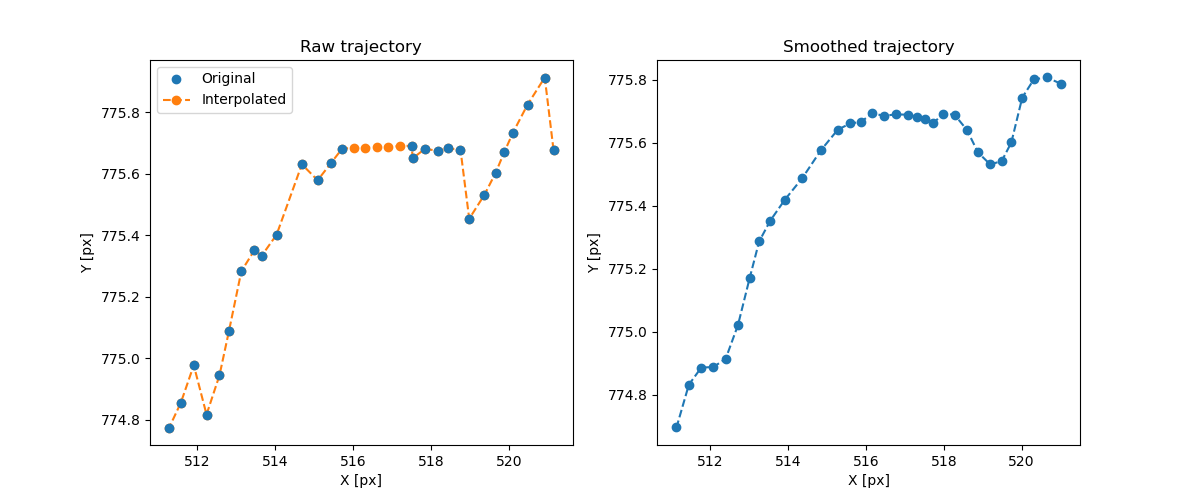

In [59]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 5))
ax.plot(df1.x, df1.y, 'o', label = 'Original', zorder = 20)
ax.plot(df2.x, df2.y, '--o', label = 'Interpolated', zorder = 10)
ax1.plot(df3.x, df3.y, '--o', label = 'Smoothed', zorder = 10)
ax.set(xlabel = 'X [px]', ylabel = 'Y [px]', title = 'Raw trajectory')
ax1.set(xlabel = 'X [px]', ylabel = 'Y [px]', title = 'Smoothed trajectory')
ax.legend()
plt.savefig(save_path + f'interp_smoothing_example_linear.png', dpi = 500)
plt.show()